In [1]:
import sys

!{sys.executable} -m pip install iminuit==2.2.1

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/bin/python3.6m -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
fName = '/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/datafortres.csv'

In [4]:
data = pd.read_csv(fName)

vData2 [[-2.95808539e+00  6.18495839e+01]
 [-3.52602825e+01  2.86546117e+01]
 [-7.81839955e+01  2.46316185e+05]
 ...
 [-2.18337588e+01  1.65001687e+01]
 [-4.11162153e+00  1.89113733e+01]
 [-1.17881615e+02  1.40098119e+02]]
pred limitom 464952
result [[  -2.95808539   61.84958387]
 [ -35.26028246   28.65461167]
 [  74.24321026   38.78798103]
 ...
 [ -21.8337588    16.50016871]
 [  -4.11162153   18.91137334]
 [-117.88161471  140.09811915]]
dlzka po 463216


((array([0.0001902 , 0.00019711, 0.00021168, 0.00022395, 0.00023085,
         0.0002623 , 0.00025616, 0.0002761 , 0.00030218, 0.00031292,
         0.00034973, 0.00035586, 0.00035356, 0.00042872, 0.00043563,
         0.00046554, 0.00049852, 0.00050005, 0.00054453, 0.00062813,
         0.00068412, 0.00078075, 0.00074164, 0.00086359, 0.00093491,
         0.00101851, 0.00111975, 0.00124859, 0.00136517, 0.00152623,
         0.00170109, 0.00186752, 0.00222185, 0.00245731, 0.00276025,
         0.0030655 , 0.00365451, 0.00411929, 0.00467226, 0.00530499,
         0.00604356, 0.00678214, 0.00776076, 0.00864506, 0.00960758,
         0.01055246, 0.0112872 , 0.01187391, 0.01243302, 0.01291466,
         0.01287785, 0.01271449, 0.01241078, 0.0120112 , 0.01138153,
         0.01068898, 0.00967737, 0.0089365 , 0.00815114, 0.00747239,
         0.00658426, 0.00607041, 0.00545838, 0.00487396, 0.00452117,
         0.00391681, 0.00366065, 0.00332396, 0.00302332, 0.00266208,
         0.00256698, 0.0022487 , 0

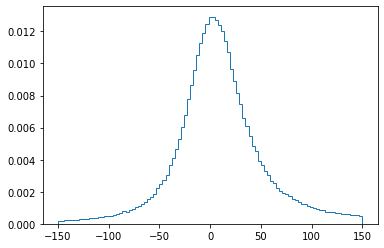

In [5]:
vData1 = data['tagvlres'].to_numpy()
sigmas = data['tagvlerr'].to_numpy()

vData1.resize(min(len(vData1), len(vData1)))
sigmas.resize(min(len(sigmas), len(sigmas)))
vData1.size, sigmas.size
vData2 = np.column_stack((vData1,sigmas))
vData2 = vData2[~np.isnan(vData2).any(axis=1)]
print('vData2', vData2)
print('pred limitom', len(vData2))
vData = np.where(vData2[:,1] < 80000)
vData = vData2[vData]
print('result',vData)
print('dlzka po', len(vData))

plt.hist(vData[:,0], histtype='step', density = True, bins=np.linspace(-150, 150, 100)),

In [10]:
def gausInt(a, b, c, d):
     m = d / c
     s = 1./np.sqrt(c)
     from math import erf
     res = np.sqrt(np.pi)/(2*np.sqrt(c)) * (erf((b*c-d)/np.sqrt(c)) - erf((a*c-d)/np.sqrt(c)))
     #print('resgaus',res)
     return res

def convExpGaus(sK, tau, x):
     c = 1./(2*sK*sK)
     #print('mus - z', x)
     #print ('c',c)
     d = 0.5*(x/sK/sK - 1/tau)
     #print('d',d)
     #print('konst part', 1./(np.sqrt(2*np.pi) *sK* tau))
     #print('power', pow(x/sK,2))
     #print('dc', d*d/c)
     #print('argument exp',-1./2 * pow(x/sK,2) + d*d/c)
     print('expon',np.exp(-1./2 * pow(x/sK,2) + d*d/c))
     Const = 1./(np.sqrt(2*np.pi) *sK* tau) * np.exp(-1./2 * pow(x/sK,2) + d*d/c)
     #print('const',Const)
     return Const * gausInt(0, 1e15, c, d);
  
def Gauss(x, mean, sigma):
    f = 1./(np.sqrt(2*np.pi)*sigma) * np.exp( -1./2 * pow((x-mean)/sigma, 2))
    return f

def mu(sigma,mu0,mu1):
    res_mus = mu0 + mu1*sigma
    return res_mus

       
def sus(sigma,s0,s1):
    res_sus = s0 + s1*sigma
    return res_sus 
         
def f_TMains(sigma,f_mu,f_sig, f_Mmax):
    from math import erf
    res_fTMains = (f_Mmax)*erf((f_mu-sigma)/(np.sqrt(2)*f_sig))
    return res_fTMains
       
def f_TBigs(sigma,f_mu,f_sig, f_Bmax):
    from math import erf
    res_fTBigs = (f_Bmax)*erf((f_mu-sigma)/(np.sqrt(2)*f_sig))
    return res_fTBigs
        
def f_cLMs(sigma,c0LM, c1LM): 
    res_cLMs = (c0LM + c1LM*sigma)
    return res_cLMs
      
def f_cRMs(sigma,c0RM, c1RM): 
    res_cRMs = (c0RM + c1RM*sigma)
    return res_cRMs
        
def f_cB(sigma,c0B,c1B):
    res_CB = (c0B + c1B*sigma)
    return res_CB 


def fun(x, pars):   
 
    z = x[0]
    #print('z',z)
    sigmas = x[1]
    #print('sigmas',sigmas)
    
    f_mu = pars["f_mu"]
    f_sig = pars["f_sig"]
    f_Mmax = pars["f_Mmax"]    
    fTR = pars["fTR"]           
    mu0 = pars["mu0"]
    mu1 = pars["mu1"]
    s0 = pars["s0"]
    s1 = pars["s1"]    
    bigSigmaFrac = pars['bigSigmaFrac']        
    bigSigmaScale = pars['bigSigmaScale']
    f_Bmax = pars["f_Bmax"] 
    c0RM = pars['c0RM']
    c1RM = pars['c1RM']
    c0LM = pars['c0LM']
    c1LM = pars["c1LM"]
    c0B = pars["c0B"]
    c1B = pars["c1B"]
    fTR  = pars["fTR"]       
    bigSigmaFrac = pars['bigSigmaFrac']
    bigSigmaScale = pars['bigSigmaScale'] 
    
    
       
    mus = mu(sigmas, mu0, mu1)
    #print('mu',mus)
    s = sus(sigmas, s0, s1)
    #print('s',s)
    fTMains = f_TMains(sigmas, f_mu,f_sig, f_Mmax)  
    #print('fTMains',fTMains)
    fTBigs = f_TBigs(sigmas, f_mu, f_sig, f_Bmax)
    #print('fTBigs',fTBigs)
    cLMs = f_cLMs(sigmas, c0LM, c1LM)
    #print('clms', cLMs)
    cRMs = f_cRMs(sigmas, c0RM, c1RM)
    #print('crms', cRMs)
    fcB = f_cB(sigmas, c0B, c1B)  
    #print('fcB', fcB)
    gaus = Gauss(z, mean=mus,sigma=s)  
    #print('gas',gaus)
    gausB = Gauss(z, mean=mus, sigma=s*bigSigmaScale)
    #print('gausB',gausB)
    conv = convExpGaus(s, 1./cLMs, mus - z) 
   # print('conv',conv)
    ret = 0    
    
    # small gauss
    ret += (1-bigSigmaFrac) * (1-fTMains) * gaus 
    #print('ret 1 s',ret)
    ret += (1-bigSigmaFrac) * fTMains*(1.-fTR)*conv
    #print('ret 2 s',ret)
    ret += (1-bigSigmaFrac) * fTMains*(fTR)*convExpGaus(s, 1./cRMs,  z - mus )
    #print('ret 3 s',ret)
    # big gauss
    ret += bigSigmaFrac * (1-fTBigs) * gausB 
    #print('ret 1 b',ret)
    ret += bigSigmaFrac * fTBigs*(1.-fTR)*convExpGaus(bigSigmaScale*s, 1./cLMs, mus - z)
    #print('ret 2 b',ret)
    ret += bigSigmaFrac * fTBigs*(fTR)*convExpGaus(bigSigmaScale*s, 1./cRMs,  z - mus )
    #print('ret 3 b',ret)
    
    return ret




In [17]:
%xmode Verbose
import chebFitter2D as chf
xLim = 80000
sLim = 80000
ch = chf.chebFitter(128 + 1, -xLim, xLim, 128 + 1, -sLim, sLim, vData, fun)
#pars = {"mu0" : 0.2, "mu1" : 0.5, "s0" : 30, "s1" :4, "f_mu" : 0.7, "f_sig" : 0.5, "f_Mmax" : 0.5, "fTR" :0.5,
#        "bigSigmaScale" : 5, "bigSigmaFrac" : 3, "f_Bmax" : 0.5, "c0RM" : 0.1, "c1RM" : 0.1, "c0LM" : 0.1, "c1LM" : 0.1,
 #                               "c0B" : 0.1, "c1B" : 0.1 }
pars = {
    'mu0': 300000000, 
    'mu1': -2000000.5998222326911318,   
    's0' : 1, 
    's1' :0.00001,    
    'f_mu' : 0.6879121782503139,
    'f_sig' : 0.6879121782503139,
    'f_Mmax' : 0.6879121782503139,    
     'fTR': 0.5672982488332009,
     'bigSigmaScale': 30,
     'bigSigmaFrac': 0.16756917570490554,
    'f_Bmax' : 0.6268934047143494,
     'c0RM': 0.02771982014064649,
    'c1RM' : 0.002771982014064649,
    'c0LM' : 0.03847980216578396,
    'c1LM' : 0.003847980216578396,
    'c0B' : 0.03812636576085269,
    'c1B' : 0.006550526360797996  
    
    
}
Limits = { 
        'mu0': (-10, 10),
        'mu1': (-10, 10),
        's0' : (2, 40),
        's1' : (2, 40),
        'f_mu' : (0, 1),
        'f_sig' : (0, 1),
        'f_Mmax' : (0, 10),    
        'fTR': (0, 1),
        'c0RM': (1e-5, 0.1),
        'c1RM' : (1e-5, 0.1),
        'c0LM' : (1e-5, 0.1),
        'c1LM' : (1e-5, 0.1),
        'c0B' : (1e-5, 0.1),
        'c1B' : (1e-5, 0.1),
        "bigSigmaScale": (3, 40),
        'bigSigmaFrac' : (0,1),
        'f_Bmax': (0,1)    
        }


res =  ch.fitData(pars)
print(res)


Exception reporting mode: Verbose
Loading data grid
-80000.0
80000.0
-80000.0
80000.0
datanorm [[0.49998151 0.50038656]
 [0.49977962 0.50017909]
 [0.50046402 0.50024242]
 ...
 [0.49986354 0.50010313]
 [0.4999743  0.5001182 ]
 [0.49926324 0.50087561]]
Done
(16641, 16641)
(16641,)
vramci init x0 [-2.95808539 61.84958387]
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon 0.0
expon inf
expon 0.0
expon inf
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon 

expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0


expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf


expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf


expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0
expon inf
expon 0.0


KeyboardInterrupt: 

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


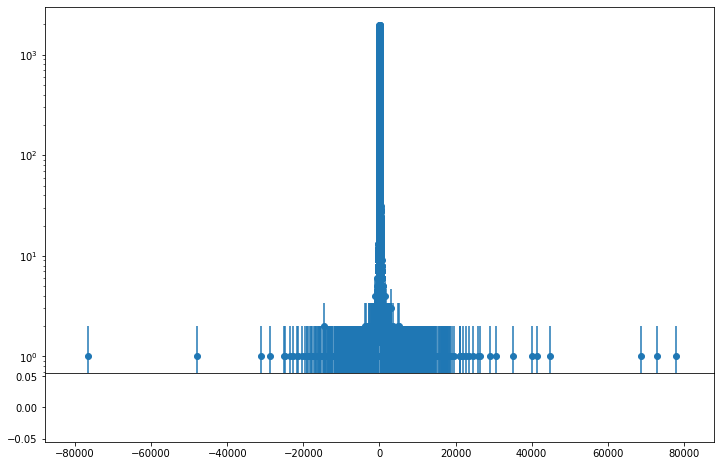

In [8]:
def plotHist(d, bins, chFit, res):
    a = d[:,0]
   
    vals, bins = np.histogram(a, bins)
    xCnt  = (bins[1:] + bins[:-1]) / 2
    xSize = (bins[1:] - bins[:-1]) / 2
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[16,3]}, figsize=(12,8))
    axs[0].set_yscale('log')
    axs[0].errorbar(xCnt, vals, xerr=xSize, yerr=np.sqrt(vals), ls='none', fmt="o")
    
    N = np.dot(vals, 2*xSize) 
    #print('bins0', bins[0])
    x = np.linspace(bins[0], bins[-1], 500)
    y = N * chFit.funFastProjX(x, res)
    axs[0].plot(x, y)
    
    # plotRatio
    yRat= N * chFit.funFastProjX(xCnt, res) 
    axs[1].errorbar(xCnt, vals/ yRat, xerr=xSize, yerr=np.sqrt(vals)/yRat, ls='none', fmt="o")
    
plotHist(vData, np.linspace(-xLim, xLim, 463217), ch, res)

    

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(vData[:,0], histtype='step', density = True, bins=40)
x  = np.linspace(-1, 1, 100)
yCh= ch2.funFastProjX(x, res)
plt.plot(x, yCh)